<a href="https://colab.research.google.com/github/pierrej0/images-selection/blob/main/W4_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import of libraries

In [ ]:

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()




     |████████████████████████████████| 727kB 7.0MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 204kB 14.1MB/s 
     |████████████████████████████████| 1.2MB 18.0MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
Mounted at /content/gdrive


In [ ]:
pip install jmd_imagescraper

In [ ]:
from jmd_imagescraper.core import *
from pathlib import Path
from fastbook import *
from fastai.vision.widgets import *
from jmd_imagescraper.imagecleaner import *
from fastai.vision.all import *


matplotlib.rc('image', cmap='Greys')

I use my images from my google drive so I mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I give the path to access the image folders

In [ ]:
#path = Path("/content/images1/")
path = Path("/content/drive/MyDrive/image selection")

In [ ]:
path.ls()

(#3) [Path('/content/drive/MyDrive/image selection/images/Mountain-black-and-white-mountain-clipart-black-and-white-free-images-9.png'),Path('/content/drive/MyDrive/image selection/images/944-9449194_landscape-mountain-mountains-clip-art-black-and-white.png'),Path('/content/drive/MyDrive/image selection/images/plogo.png')]

In [ ]:
threes = (path).ls().sorted()

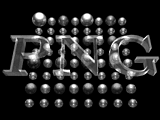

In [ ]:
im3_path = threes[2]
im3 = Image.open(im3_path)
im3

In [ ]:
im3.size

(160, 120)

In [ ]:
array(im3)[100:105,60:65]


array([[160,  89,  14,   0,   0],
       [138, 103,  42,   0,   0],
       [ 88,  66,  57,   3,   0],
       [ 64,  71,  86,  17,   0],
       [ 66,  62,  72,   7,   0]], dtype=uint8)

In [ ]:
tensor(im3)[100:105,60:65]

tensor([[160,  89,  14,   0,   0],
        [138, 103,  42,   0,   0],
        [ 88,  66,  57,   3,   0],
        [ 64,  71,  86,  17,   0],
        [ 66,  62,  72,   7,   0]], dtype=torch.uint8)

In [ ]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[90:110,50:65])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4,0,0,0,24,30,21,21,29,23,29,25,25,24,22
1,0,0,0,0,9,25,37,23,22,21,22,29,31,26,14
2,0,0,0,0,0,10,31,25,28,49,24,21,25,19,0
3,0,0,0,0,0,0,8,15,30,41,26,21,17,0,0
4,0,0,0,0,0,0,0,1,2,1,5,5,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,16,11,0,0,0,0,0
9,0,0,0,0,0,0,46,102,154,150,82,18,0,0,0


In [ ]:
from PIL import Image

In [ ]:
im = Image.open("/content/drive/MyDrive/image selection/images/plogo.png")
im.show()

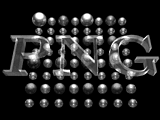

In [ ]:
im

In [ ]:
im.size

(160, 120)

In [ ]:
im1 = im.crop((110,10,150,50))
im2 = im1.save("/content/drive/MyDrive/image selection/images/plogo-resized.png")

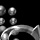

In [ ]:
im1

Turn our images in dataloaders

In [ ]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [ ]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = images.dataloaders(path)

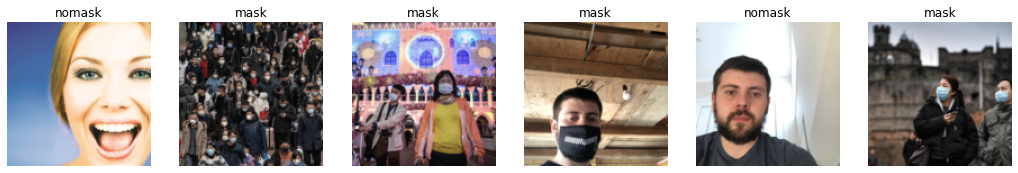

In [ ]:
dls.valid.show_batch(max_n=6, nrows=1)

I create my learner 

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.039979,0.161180,0.060000,01:24


epoch,train_loss,valid_loss,error_rate,time
0,0.514774,0.148655,0.020000,00:05
1,0.417554,0.127216,0.030000,00:05
2,0.301844,0.086846,0.040000,00:05
3,0.249130,0.076949,0.030000,00:05


Check with the confusion matrix where are the mistakes 

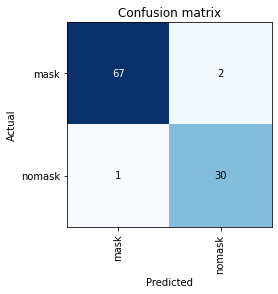

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

let's see which pictures are wrong

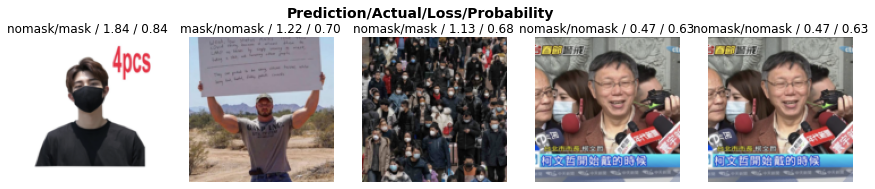

In [ ]:
interp.plot_top_losses(5, nrows=1)

Squish images : 4 images wrong

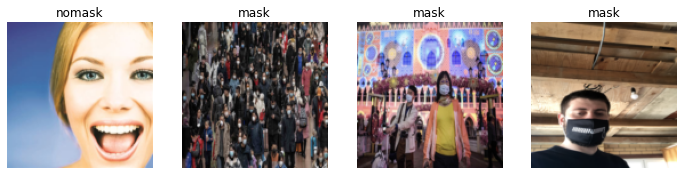

In [ ]:
images = images.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = images.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Resize images : 7 images wrong

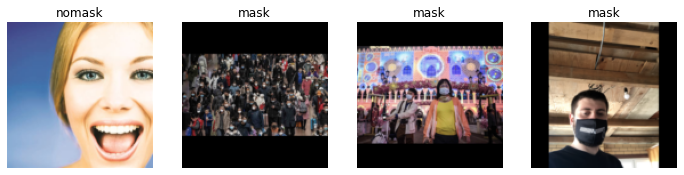

In [ ]:
images = images.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = images.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Random resized with 30% : 2 wrong(1 of each)

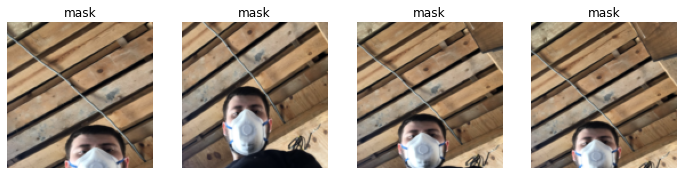

In [ ]:
images = images.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = images.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Image augmentation 2 wrong(1 of each)

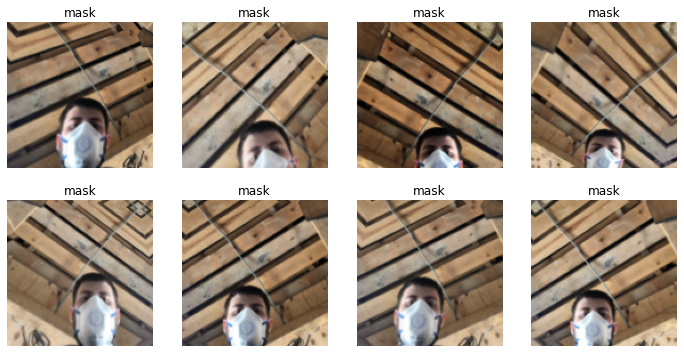

In [ ]:
images = images.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=1))
dls = images.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Image resized with 50% of the original image : 3 wrong

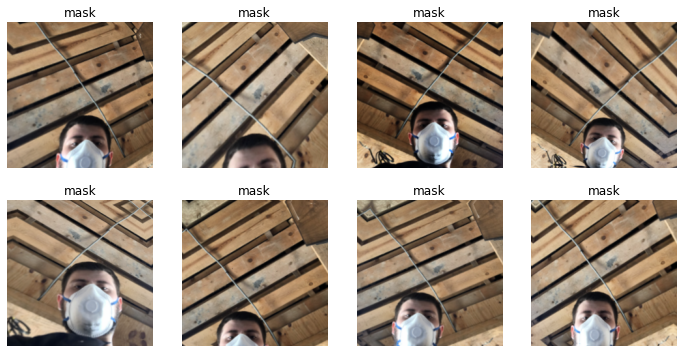

In [ ]:
images = images.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = images.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn.export()

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

get an image to test our model

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

Show the image

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

Test this image

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: mask; Probability: 0.7450')

Create a classify button

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

linked the button and info for classify image

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your image!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

IndexError: ignored